In [1]:
import pandas as pd
import logging
import subprocess
import os
import shutil
import numpy as np
import shlex
import glob
import matplotlib.pyplot as plt
import textgrid
import sox
import time
import datetime
import pydub
from pydub.playback import play
import random

In [2]:
keywords_set = set(["up", "down", "three", "yes", "no", "left", "right", "on", "off", "stop", "go"])

In [3]:
keywords = pd.read_csv("../keywords_listen.tsv", sep="\t")
print(keywords.shape[0])

112008


In [4]:
# select examples each from keywords where the column ["keywords"] == True
NUM_SAMPLES = 2000
samples = {}
for k in keywords_set:
    if keywords[k].value_counts().loc[True] > NUM_SAMPLES:
        #are there more than NUM_SAMPLES examples?
        samples[k] = keywords[keywords[k]].sample(n=NUM_SAMPLES)
    else:
        # use them all
        samples[k] = keywords[keywords[k]].copy()
        logging.warning(f"for keyword {k}, there are not enough examples to sample")
    print("Keyword", k, ":", samples[k].shape[0])    
    
# clean up each df by removing the keyword columns
for k in samples.keys():
    samples[k].drop(columns=keywords_set, inplace=True)

Keyword right : 2000
Keyword on : 2000
Keyword stop : 2000
Keyword go : 2000
Keyword up : 2000
Keyword left : 2000
Keyword three : 2000
Keyword no : 2000
Keyword off : 2000
Keyword yes : 1243
Keyword down : 2000


In [5]:
samples["yes"].head(2)

,client_id,path,sentence,up_votes,down_votes,age,gender,accent
154,6055e19ee9a2bccd2070499b4511a2c219b44e31fe4871...,common_voice_en_17393438.mp3,"Yes, it would be difficult.",2,0,NaN,NaN,NaN
260,a43bcfd1d7ad35f4ae5774295f97d0026b8a507cd8caf5...,common_voice_en_15733861.mp3,"Yes, this is the right place.",2,1,fourties,male,us


In [8]:
print(os.getcwd())

/home/mark/tinyspeech_harvard/tinyspeech/alignment


```
aligner.exceptions.CorpusError: Files with the same file name are not permitted. Files with the same name are: /work/input/clips/drei/common_voice_de_17324140.wav, /work/input/clips/links/common_voice_de_17324140.wav.
```

`Geh hinunter und hilf deinem Vater!` contains both `geh` and `hinunter`
        

In [10]:
# find files which contain more than one keyword
#keywords_set = set(["öffne", "hinunter", "drei", "ja", "nein", "links", "richtig", "auf", "aus", "halt", "geh"])
wavs = set()
for kw in keywords_set:
    # german
    # wavlist = f"../../alignment_processing/input/clips/{kw}/*.wav"
    # english
    mp3list = f"../../eleven_word_dataset/clips/{kw}/*.mp3"
    kw_clips = glob.glob(mp3list)
    kw_clips = list(map(os.path.basename, kw_clips))
    kw_clips = set(kw_clips)
    print(kw)
    print(kw_clips.intersection(wavs))
    wavs.update(kw_clips)

right
set()
on
{'common_voice_en_589566.mp3', 'common_voice_en_17785868.mp3', 'common_voice_en_18314533.mp3', 'common_voice_en_19453947.mp3', 'common_voice_en_101144.mp3', 'common_voice_en_567048.mp3', 'common_voice_en_620842.mp3', 'common_voice_en_60790.mp3', 'common_voice_en_49347.mp3', 'common_voice_en_668361.mp3'}
stop
{'common_voice_en_17268545.mp3', 'common_voice_en_18153977.mp3', 'common_voice_en_19137764.mp3', 'common_voice_en_18166159.mp3', 'common_voice_en_177128.mp3', 'common_voice_en_17693248.mp3', 'common_voice_en_697828.mp3', 'common_voice_en_550291.mp3', 'common_voice_en_17296130.mp3', 'common_voice_en_19187812.mp3', 'common_voice_en_17249223.mp3', 'common_voice_en_94242.mp3', 'common_voice_en_612695.mp3', 'common_voice_en_17959405.mp3', 'common_voice_en_17258356.mp3'}
go
{'common_voice_en_51486.mp3', 'common_voice_en_528690.mp3', 'common_voice_en_18656241.mp3', 'common_voice_en_17369478.mp3', 'common_voice_en_585081.mp3', 'common_voice_en_174153.mp3', 'common_voice_en_5

In [9]:
kw = "yes"
wavlist = f"../../eleven_word_dataset/clips/{kw}/*.mp3"
kw_wavs = glob.glob(wavlist)
kw_wavs[0]

'../../eleven_word_dataset/clips/yes/common_voice_en_615206.mp3'

In [75]:
# for kw in keywords_set:
#     dest = "../../alignment_processing_en/extractions_silencepad/"
#     os.mkdir(dest + kw)

In [21]:
for kw in keywords_set:
    clips = f"../../eleven_word_dataset/clips/{kw}/*.mp3"
    clips = glob.glob(clips)
    print(kw, len(clips))

right 2000
on 2000
stop 2000
go 2000
up 2000
left 2000
three 2000
no 2000
off 2000
yes 1243
down 2000


In [51]:
raise ValueError("caution: large fs operation")
ALIGNMENT_WORKDIR = "../../alignment_processing_en/"
for kw in keywords_set:
    clips = f"../../eleven_word_dataset/clips/{kw}/*.mp3"
    clips = glob.glob(clips)
    clips = list(map(os.path.basename, clips))
    for clip in clips:
        mp3_path = f"../../eleven_word_dataset/clips/{kw}/{clip}"
        # row in df
        row = keywords[keywords.path.str.match(clip)]
        # directory to copy wav to
        destdir = ALIGNMENT_WORKDIR + kw + os.path.sep
        
        filename_noext = os.path.splitext(clip)[0]
        
        dest = destdir + filename_noext + ".wav"
        
        utterance = row.sentence.iloc[0]
        transcription = f"{ALIGNMENT_WORKDIR}{kw}/{filename_noext}.txt"
        
        with open(transcription, 'w') as fh:
            fh.write(utterance)
        transformer = sox.Transformer()
        transformer.convert(samplerate=16000)  # from 48K mp3s
        transformer.build(mp3_path, dest)

output_file: ../../alignment_processing_en/right/common_voice_en_53984.wav already exists and will be overwritten on build


In [109]:
raise ValueError("caution: renames a lot of files")
# rename files to include the keyword (temporarily)
keywords_set = set(["öffne", "hinunter", "drei", "ja", "nein", "links", "richtig", "auf", "aus", "halt", "geh"])
for kw in keywords_set:
    kw_wavs = glob.glob(f"../../alignment_processing/input/clips/{kw}/*.wav")
    kw_txts = glob.glob(f"../../alignment_processing/input/clips/{kw}/*.txt")
    for f in kw_wavs:
        dirname, filename = os.path.split(f)
        newdest = dirname + os.path.sep + f"{kw}_" + filename
        os.rename(f, newdest)
    for f in kw_txts:
        dirname, filename = os.path.split(f)
        newdest = dirname + os.path.sep + f"{kw}_" + filename
        os.rename(f, newdest)

In [115]:
# get rid of the umlaut:
#keywords_set = set(["öffne", "hinunter", "drei", "ja", "nein", "links", "richtig", "auf", "aus", "halt", "geh"])

kw_wavs = glob.glob(f"../../alignment_processing/input/clips/offne/*.wav")
for f in kw_wavs:
    #newfile = f.replace("ö", "o")
    #os.rename(f, newfile)
    print(f)
    break
kw_txts = glob.glob(f"../../alignment_processing/input/clips/offne/*.txt")
for f in kw_wavs:
    #newfile = f.replace("ö", "o")
    #os.rename(f, newfile)
    print(f)
    break

../../alignment_processing/input/clips/offne/offne_common_voice_de_18826257.wav
../../alignment_processing/input/clips/offne/offne_common_voice_de_18826257.wav


```bash
docker run --rm  -v /home/mark/tinyspeech_harvard/alignment_processing:/work/  -t montreal  bin/mfa_align --quiet /work/input /work/lexicon/de.dict /work/lexicon/german_prosodylab.zip /work/output/

Setting up corpus information...
^NNumber of speakers in corpus: 11, average number of utterances per speaker: 1062.3636363636363
/home/mark/montreal-forced-aligner/lib/aligner/models.py:87: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
Traceback (most recent call last):
  File "aligner/command_line/align.py", line 186, in <module>
  File "aligner/command_line/align.py", line 142, in validate_args
  File "aligner/command_line/align.py", line 88, in align_corpus
  File "aligner/models.py", line 129, in validate
aligner.exceptions.PronunciationAcousticMismatchError: There were phones in the dictionary that do not have acoustic models: 
[7] Failed to execute script align
```

Ok, guess I am using the wrong zip file? Trying `german_prosodylab_g2p.zip` instead:

```bash
docker run --rm  -v /home/mark/tinyspeech_harvard/alignment_processing:/work/  -t montreal  bin/mfa_align --quiet /work/input /work/lexicon/de.dict /work/lexicon/german_prosodylab_g2p.zip /work/output/

Setting up corpus information...
Number of speakers in corpus: 11, average number of utterances per speaker: 1062.3636363636363
/home/mark/montreal-forced-aligner/lib/aligner/models.py:87: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
Creating dictionary information...
Traceback (most recent call last):
  File "aligner/command_line/align.py", line 186, in <module>
  File "aligner/command_line/align.py", line 142, in validate_args
  File "aligner/command_line/align.py", line 94, in align_corpus
  File "aligner/aligner/pretrained.py", line 74, in __init__
  File "aligner/aligner/pretrained.py", line 122, in setup
  File "aligner/aligner/base.py", line 89, in setup
  File "aligner/corpus.py", line 962, in initialize_corpus
  File "aligner/corpus.py", line 765, in write
  File "aligner/corpus.py", line 776, in _write_speak_utt
  File "aligner/corpus.py", line 28, in output_mapping
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 0-1: surrogates not allowed
[6] Failed to execute script align

```

Might be caused by `os.walk` running into a directory with an umlaut?

Renaming the dir:
`alignment_processing/input/clips$ mv öffne offne`

Got farther

```bash
Setting up corpus information...
Number of speakers in corpus: 11, average number of utterances per speaker: 1062.3636363636363
/home/mark/montreal-forced-aligner/lib/aligner/models.py:87: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
Creating dictionary information...
Traceback (most recent call last):
  File "aligner/command_line/align.py", line 186, in <module>
  File "aligner/command_line/align.py", line 142, in validate_args
  File "aligner/command_line/align.py", line 94, in align_corpus
  File "aligner/aligner/pretrained.py", line 74, in __init__
  File "aligner/aligner/pretrained.py", line 122, in setup
  File "aligner/aligner/base.py", line 89, in setup
  File "aligner/corpus.py", line 962, in initialize_corpus
  File "aligner/corpus.py", line 765, in write
  File "aligner/corpus.py", line 776, in _write_speak_utt
  File "aligner/corpus.py", line 28, in output_mapping
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 6-7: surrogates not allowed
```

still goofing though


In [54]:
COMMON_VOICE = "../../eleven_word_dataset/clips/"
WORKDIR = "../../alignment_processing_en/"

In [58]:
kwset = list(keywords_set)
kwset

['right',
 'on',
 'stop',
 'go',
 'up',
 'left',
 'three',
 'no',
 'off',
 'yes',
 'down']

In [62]:
abs_workdir = os.path.abspath(WORKDIR)

# english
kw = kwset[0]
mfa = f"bin/mfa_align --quiet /work/{kw}/ /work/lexicon/librispeech-lexicon.txt pretrained_models/english.zip /work/output/{kw}/"
# german
#KEYWORD = "richtig"
#mfa = f"bin/mfa_align -j 5 --quiet /work/input/clips/{KEYWORD}/ /work/lexicon/de.dict /work/lexicon/german_prosodylab.zip /work/output/{KEYWORD}/"

# non-interactive command (no terminal emulation with -i)
cmd = f"""docker run --rm \
 -v {abs_workdir}:/work/ \
 -t montreal \
 {mfa}"""
print(cmd)
shlex.split(cmd)

docker run --rm -v /home/mark/tinyspeech_harvard/alignment_processing_en:/work/ -it montreal bin/mfa_align --quiet /work/right/ /work/lexicon/librispeech-lexicon.txt pretrained_models/english.zip /work/output/right/


['docker',
 'run',
 '--rm',
 '-v',
 '/home/mark/tinyspeech_harvard/alignment_processing_en:/work/',
 '-it',
 'montreal',
 'bin/mfa_align',
 '--quiet',
 '/work/right/',
 '/work/lexicon/librispeech-lexicon.txt',
 'pretrained_models/english.zip',
 '/work/output/right/']

In [68]:
# interactive version (-i flag) to be run from the terminal
for kw in kwset:
    mfa = f"bin/mfa_align --quiet /work/{kw}/ /work/lexicon/librispeech-lexicon.txt pretrained_models/english.zip /work/output/{kw}/"
    cmd = f"""docker run --rm \
             -v {abs_workdir}:/work/ \
             -it montreal \
             {mfa}"""
    # combine spaces
    cmd = " ".join(cmd.split())
    #print(kw, "\n\n", cmd, "\n-")
    print(cmd)

docker run --rm -v /home/mark/tinyspeech_harvard/alignment_processing_en:/work/ -t montreal bin/mfa_align --quiet /work/right/ /work/lexicon/librispeech-lexicon.txt pretrained_models/english.zip /work/output/right/
docker run --rm -v /home/mark/tinyspeech_harvard/alignment_processing_en:/work/ -t montreal bin/mfa_align --quiet /work/on/ /work/lexicon/librispeech-lexicon.txt pretrained_models/english.zip /work/output/on/
docker run --rm -v /home/mark/tinyspeech_harvard/alignment_processing_en:/work/ -t montreal bin/mfa_align --quiet /work/stop/ /work/lexicon/librispeech-lexicon.txt pretrained_models/english.zip /work/output/stop/
docker run --rm -v /home/mark/tinyspeech_harvard/alignment_processing_en:/work/ -t montreal bin/mfa_align --quiet /work/go/ /work/lexicon/librispeech-lexicon.txt pretrained_models/english.zip /work/output/go/
docker run --rm -v /home/mark/tinyspeech_harvard/alignment_processing_en:/work/ -t montreal bin/mfa_align --quiet /work/up/ /work/lexicon/librispeech-lexi

In [58]:
p = subprocess.Popen(
    shlex.split(cmd),
    stderr=subprocess.PIPE,
    stdout=subprocess.PIPE,
)

In [59]:
sout, serr = p.communicate()
print(sout.decode("UTF-8"), serr.decode("UTF-8"), p.returncode)

Setting up corpus information...
Number of speakers in corpus: 1, average number of utterances per speaker: 15.0
/home/mark/montreal-forced-aligner/lib/aligner/models.py:87: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
Creating dictionary information...
Setting up training data...
Calculating MFCCs...
Calculating CMVN...
Number of speakers in corpus: 1, average number of utterances per speaker: 15.0
Done with setup.
100% 2/2 [00:03<00:00,  1.84s/it]
Done! Everything took 9.433974981307983 seconds
  0


In [117]:
tgs = glob.glob(f"{WORKDIR}/output/halt/*.TextGrid")
print(len(tgs))

625


In [74]:
os.getcwd()

'/home/mark/tinyspeech_harvard/tinyspeech/alignment'

In [77]:
SILENCE_PAD = True

for kw in kwset:
    tgs = glob.glob(f"{WORKDIR}/output/{kw}/{kw}/*.TextGrid")
    print(kw, len(tgs))
    sourcedir = f"../../eleven_word_dataset/clips/{kw}/"
    
    for ix,tgf in enumerate(tgs):
        if ix % 250 == 0:
            print(kw, "ix",ix)
        tg = textgrid.TextGrid.fromFile(tgf)
        filename_noext = os.path.basename(os.path.splitext(tgf)[0])
        for interval in tg[0]:
            if interval.mark == kw:
                start_s = interval.minTime
                end_s = interval.maxTime
                #print(start_s, end_s)
                
                dest = f"../../alignment_processing_en/extractions_silencepad/{kw}/{filename_noext}.wav"

                wav_path = f"../../alignment_processing_en/{kw}/{filename_noext}.wav"
                duration = sox.file_info.duration(wav_path)
                #if duration < 1:
                #    logging.warning(f"{keyword} clip ix {ix} shorter than 1s")

                if not SILENCE_PAD:
                    # with surrounding context
                    start_s, end_s = extract_one_second(duration, start_s, end_s)
                else:
                    if end_s - start_s < 1:
                        pad_amt_s = (1. - (end_s - start_s))/2.
                    else: # utterance is already longer than 1s, trim instead
                        start_s, end_s = extract_one_second(duration, start_s, end_s)
                        pad_amt_s = 0


                transformer = sox.Transformer()
                # alrady 16K
                #transformer.convert(samplerate=16000)  # from 48K mp3s
                transformer.trim(start_s, end_s)
                if not SILENCE_PAD:
                    transformer.fade(fade_in_len=0.1, fade_out_len=0.1)
                else:
                    # use smaller fadein/fadeout since we are capturing just the word
                    # TODO(mmaz) is this appropriately sized?
                    transformer.fade(fade_in_len=0.025, fade_out_len=0.025)
                    transformer.pad(start_duration=pad_amt_s, end_duration=pad_amt_s)
                transformer.build(wav_path, dest)
                #print(dest)
                break # TODO(mmaz) only select the first occurence of the desired wordmark from TextGrid
#         break
#     break

output_file: ../../alignment_processing_en/extractions_silencepad/right/common_voice_en_92763.wav already exists and will be overwritten on build


right 1997
right ix 0
right ix 250
right ix 500
right ix 750
right ix 1000
right ix 1250
right ix 1500
right ix 1750
on 1989
on ix 0
on ix 250
on ix 500
on ix 750
on ix 1000
on ix 1250
on ix 1500
on ix 1750
stop 1994
stop ix 0
stop ix 250
stop ix 500
stop ix 750
stop ix 1000
stop ix 1250
stop ix 1500
stop ix 1750
go 1992
go ix 0
go ix 250
go ix 500
go ix 750
go ix 1000
go ix 1250
go ix 1500
go ix 1750
up 1990
up ix 0
up ix 250
up ix 500
up ix 750
up ix 1000
up ix 1250
up ix 1500
up ix 1750
left 1993
left ix 0
left ix 250
left ix 500
left ix 750
left ix 1000
left ix 1250
left ix 1500
left ix 1750
three 1988
three ix 0
three ix 250
three ix 500
three ix 750
three ix 1000
three ix 1250
three ix 1500
three ix 1750
no 1991
no ix 0
no ix 250
no ix 500
no ix 750
no ix 1000
no ix 1250
no ix 1500
no ix 1750
off 1991
off ix 0
off ix 250
off ix 500
off ix 750
off ix 1000
off ix 1250
off ix 1500
off ix 1750
yes 1242
yes ix 0
yes ix 250
yes ix 500
yes ix 750
yes ix 1000
down 1992
down ix 0
down ix 

Got this one wrong: `common_voice_en_18668331.mp3` - lot of noise in background

In [118]:
tg = textgrid.TextGrid.fromFile(tgs[0])

for i in range(len(tg[0])):
    print(tg[0][i])

Interval(0.0, 1.16, None)
Interval(1.16, 1.38, ach)
Interval(1.38, 1.89, egal)
Interval(1.89, 2.06, None)
Interval(2.06, 2.23, dann)
Interval(2.23, 2.51, nehme)
Interval(2.51, 2.66, ich)
Interval(2.66, 2.93, halt)
Interval(2.93, 3.22, einen)
Interval(3.22, 3.59, neuen)
Interval(3.59, 4.464, None)


In [66]:
i = tg[0][2]
i.minTime, i.maxTime, i.mark

(0.84, 1.13, 'öffne')

In [73]:
def extract_one_second(duration_s: float, start_s: float, end_s: float):
    """
    return one second around the midpoint between start_s and end_s
    """
    if duration_s < 1:
        return (0, duration_s)

    center_s = start_s + ((end_s - start_s) / 2.0)

    new_start_s = center_s - 0.5
    new_end_s = center_s + 0.5

    if new_end_s > duration_s:
        new_end_s = duration_s
        new_start_s = duration_s - 1.0

    if new_start_s < 0:
        new_start_s = 0
        new_end_s = np.minimum(duration_s, new_start_s + 1.0)

#     print(
#         "start",
#         new_start_s,
#         "end",
#         new_end_s,
#         "\nduration",
#         new_end_s - new_start_s,
#         "midpoint",
#         new_start_s + ((new_end_s - new_start_s) / 2.0),
#     )
    return (new_start_s, new_end_s)

In [75]:
for tgf in tgs:
    tg = textgrid.TextGrid.fromFile(tgf)
    print(tgf)
    filename_noext = os.path.basename(os.path.splitext(tgf)[0])
    for interval in tg[0]:
        print(interval.mark)

../../alignment_processing//output/input/common_voice_de_18826257.TextGrid
../../alignment_processing//output/input/common_voice_de_18666304.TextGrid
../../alignment_processing//output/input/common_voice_de_18643584.TextGrid
../../alignment_processing//output/input/common_voice_de_19012318.TextGrid
../../alignment_processing//output/input/common_voice_de_18916371.TextGrid
../../alignment_processing//output/input/common_voice_de_19027821.TextGrid
../../alignment_processing//output/input/common_voice_de_18958253.TextGrid
../../alignment_processing//output/input/common_voice_de_18601528.TextGrid
../../alignment_processing//output/input/common_voice_de_18696772.TextGrid
../../alignment_processing//output/input/common_voice_de_18624676.TextGrid
../../alignment_processing//output/input/common_voice_de_18556969.TextGrid
../../alignment_processing//output/input/common_voice_de_18525434.TextGrid
../../alignment_processing//output/input/common_voice_de_18527803.TextGrid
../../alignment_processin

In [184]:
keywords_set = set(["öffne", "hinunter", "drei", "ja", "nein", "links", "richtig", "auf", "aus", "halt", "geh"])


In [199]:
KEYWORD = "richtig"
tgs = glob.glob(f"{WORKDIR}/output/{KEYWORD}/{KEYWORD}/*.TextGrid")
#tgs = glob.glob(f"../../alignment_processing/output/halt/halt_textgrids/*.TextGrid")
sourcedir = f"{WORKDIR}/input/clips/{KEYWORD}/"
print(len(tgs))
print(sourcedir)

PAD = True

for ix,tgf in enumerate(tgs):
    if ix % 115 == 0:
        print("ix",ix)
    tg = textgrid.TextGrid.fromFile(tgf)
    filename_noext = os.path.basename(os.path.splitext(tgf)[0])
    for interval in tg[0]:
        if interval.mark == KEYWORD:
            start_s = interval.minTime
            end_s = interval.maxTime
            #print(start_s, end_s)
            
            wav_path = f"../../alignment_processing/input/clips/{KEYWORD}/{filename_noext}.wav"
            duration = sox.file_info.duration(wav_path)
            #if duration < 1:
            #    logging.warning(f"{keyword} clip ix {ix} shorter than 1s")

            dest = f"../../alignment_processing/de_extractions_padding/{KEYWORD}/{filename_noext}.wav"

            
            if not PAD:
                # with surrounding context
                start_s, end_s = extract_one_second(duration, start_s, end_s)
            else:
                if end_s - start_s < 1:
                    pad_amt_s = (1. - (end_s - start_s))/2.
                else: # utterance is already longer than 1s, trim instead
                    start_s, end_s = extract_one_second(duration, start_s, end_s)
                    pad_amt_s = 0
            
            
            transformer = sox.Transformer()
            # alrady 16K
            #transformer.convert(samplerate=16000)  # from 48K mp3s
            transformer.trim(start_s, end_s)
            if not PAD:
                transformer.fade(fade_in_len=0.1, fade_out_len=0.1)
            else:
                # use smaller fadein/fadeout since we are capturing just the word
                # TODO(mmaz) is this appropriately sized?
                transformer.fade(fade_in_len=0.025, fade_out_len=0.025)
                transformer.pad(start_duration=pad_amt_s, end_duration=pad_amt_s)
            transformer.build(wav_path, dest)
            #print(dest)
            break # TODO(mmaz) only select the first occurence of the desired wordmark from TextGrid

867
../../alignment_processing//input/clips/richtig/
ix 0
ix 115
ix 230
ix 345
ix 460
ix 575
ix 690
ix 805


In [216]:
# listen randomly
KEYWORD = "ja"
clips = glob.glob(f"../../alignment_processing/de_extractions_padding/{KEYWORD}/*.wav")
#clips = glob.glob(f"../../alignment_processing/de_extractions/{KEYWORD}/*.wav")
random.shuffle(clips)
for ix,e in enumerate(clips[:10]):
    clip = pydub.AudioSegment.from_wav(e)
    fn = f"../../alignment_processing/input/clips/{KEYWORD}/" + os.path.splitext(os.path.split(e)[1])[0] + ".txt"
    with open(fn, 'r') as fh:
        print(ix, " : ", fh.read())
    play(clip)

0  :  Ja, aber das Wachstum ist komplett auf Pump finanziert.
1  :  Hätte ich mir ja auch denken können.
2  :  Ja nee ist klar.
3  :  Der Text lässt sich ja für unsere Zwecke adaptieren.
4  :  ja
5  :  Das ist ja fürchterlich mit diesen schwarzen Balken überall!
6  :  ja
7  :  Im Gegensatz zu Tränen und Schweiß ist Speichel nicht salzig, sonst hätte man ja auch ständig Durst.
8  :  Kosmetik ist im Grunde genau so unnötig wie Werbung, weil sie ja eine Form der Werbung ist.
9  :  ja


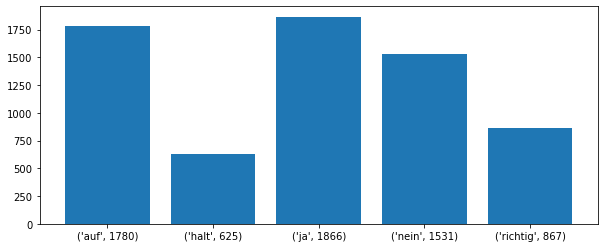

In [223]:
# label counts
wanted_words = ["auf", "halt", "ja", "nein", "richtig"]
datadir = "../../alignment_processing/de_extractions/"
counts = []
for w in wanted_words:
    counts.append(len(glob.glob(datadir + w + os.path.sep + "*.wav")))
fig, ax = plt.subplots()
ax.set_xticks(range(len(wanted_words)))
ax.set_xticklabels(zip(wanted_words, counts))
fig.patch.set_facecolor('white')
#ax.set_ylim(0,2000)
ax.bar(range(len(wanted_words)), counts);
fig.set_size_inches(10,4)

In [ ]:
row = samples["yes"].sample(n=1)
print(row.sentence.item())
row

In [87]:
wavs = glob.glob("/home/mark/tinyspeech_harvard/alignment_processing/input/*.wav")
txts = glob.glob("/home/mark/tinyspeech_harvard/alignment_processing/input/*.txt")
tgs = glob.glob("/home/mark/tinyspeech_harvard/alignment_processing/output/input/*.TextGrid")
for f in wavs + txts + tgs:
    os.remove(f)
try:
    os.rmdir("/home/mark/tinyspeech_harvard/alignment_processing/output/input/")
except FileNotFoundError:
    pass
try:
    os.remove("/home/mark/tinyspeech_harvard/alignment_processing/output/oovs_found.txt")
except FileNotFoundError:
    pass
try:
    os.remove("/home/mark/tinyspeech_harvard/alignment_processing/output/utterance_oovs.txt")
except FileNotFoundError:
    pass

In [28]:
mp3_path = COMMON_VOICE + row.path.item()
print(mp3_path)
filename_noext = os.path.basename(os.path.splitext(mp3_path)[0])

dest = f"{WORKDIR}/input/{filename_noext}.wav"

transformer = sox.Transformer()
transformer.convert(samplerate=16000)  # from 48K mp3s
#transformer.trim(start_s, end_s)
#transformer.fade(fade_in_len=0.1, fade_out_len=0.1)
transformer.build(mp3_path, dest)

utterance = row.sentence.item()
transcription = f"{WORKDIR}/input/{filename_noext}.txt"
print(transcription)
with open(transcription, 'w') as fh:
    fh.write(utterance)

../../common_voice/en/clips/common_voice_en_18483693.mp3
../../alignment_processing//input/common_voice_en_18483693.txt


In [134]:
keywords_set = set(["öffne", "hinunter", "drei", "ja", "nein", "links", "richtig", "auf", "aus", "halt", "geh"])
DATASET = "../../eleven_word_dataset_de/clips/"
WORKDIR = "../../alignment_de/"

to_process = []

for kw in keywords_set:
    clips = glob.glob(DATASET + kw + os.sep + "*.wav")
    for clip in clips:
        #print(clip)
        dirname, filename = os.path.split(clip)
        txt = dirname + os.path.sep + os.path.splitext(filename)[0] + ".txt"
        to_process.append((clip, txt))
        #print(to_process)
print(len(to_process))

11686


In [139]:
mfa = "bin/mfa_align --quiet /work/input /work/lexicon/de.dict /work/lexicon/german_prosodylab.zip /work/output/"
abs_workdir = "/home/mark/tinyspeech_harvard/alignment_de/"

cmd = f"""docker run --rm \
 -v {abs_workdir}:/work/ \
 -t montreal \
 {mfa}"""
print(cmd)
shlex.split(cmd)

docker run --rm  -v /home/mark/tinyspeech_harvard/alignment_de/:/work/  -t montreal  bin/mfa_align --quiet /work/input /work/lexicon/de.dict /work/lexicon/german_prosodylab.zip /work/output/


['docker',
 'run',
 '--rm',
 '-v',
 '/home/mark/tinyspeech_harvard/alignment_de/:/work/',
 '-t',
 'montreal',
 'bin/mfa_align',
 '--quiet',
 '/work/input',
 '/work/lexicon/de.dict',
 '/work/lexicon/german_prosodylab.zip',
 '/work/output/']

In [137]:
WORKDIR

'../../alignment_de/'

In [147]:
(4 * len(to_process)) / 60 **2

12.984444444444444

In [145]:
raise ValueError("caution: modifies fs")
errors = []
for ix, (wav,txt) in enumerate(to_process):
    start = datetime.datetime.now()
    shutil.copy2(wav, WORKDIR + "/input")
    shutil.copy2(txt, WORKDIR + "/input")
    
    dirname, wav_filename = os.path.split(wav)
    file_noext = os.path.splitext(wav_filename)[0]
    print(wav_filename)
    
    tmp_wav = WORKDIR + "input/" + file_noext + ".wav"
    tmp_txt = WORKDIR + "input/" + file_noext + ".txt"
    print(tmp_wav, tmp_txt)
    
    p = subprocess.Popen(
        shlex.split(cmd),
        stderr=subprocess.PIPE,
        stdout=subprocess.PIPE,
    )
    sout, serr = p.communicate()
    print(sout.decode("UTF-8"), serr.decode("UTF-8"), p.returncode)
    
    if p.returncode != 0:
        errors.append([ix, sout.decode("UTF-8"), serr.decode("UTF-8") ])
        
    #os.remove()
    
    wavs = glob.glob("/home/mark/tinyspeech_harvard/alignment_de/input/*.wav")
    txts = glob.glob("/home/mark/tinyspeech_harvard/alignment_de/input/*.txt")
    #tgs = glob.glob("/home/mark/tinyspeech_harvard/alignment_de/output/input/*.TextGrid")
    tgs = []
    for f in wavs + txts + tgs:
        os.remove(f)
    try:
        os.rmdir("/home/mark/tinyspeech_harvard/alignment_de/output/input/")
    except FileNotFoundError:
        pass
    try:
        os.remove("/home/mark/tinyspeech_harvard/alignment_de/output/oovs_found.txt")
    except FileNotFoundError:
        pass
    try:
        os.remove("/home/mark/tinyspeech_harvard/alignment_de/output/utterance_oovs.txt")
    except FileNotFoundError:
        pass
    
    end = datetime.datetime.now()
    print(end - start)
    break

common_voice_de_18353790.wav
../../alignment_de/input/common_voice_de_18353790.wav ../../alignment_de/input/common_voice_de_18353790.txt
Setting up corpus information...
Number of speakers in corpus: 1, average number of utterances per speaker: 1.0
/home/mark/montreal-forced-aligner/lib/aligner/models.py:87: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
Creating dictionary information...
Setting up training data...
Calculating MFCCs...
Calculating CMVN...
Number of speakers in corpus: 1, average number of utterances per speaker: 1.0
Done with setup.
100% 2/2 [00:01<00:00,  1.41it/s]
Done! Everything took 4.184454679489136 seconds
  0
0:00:04.986833
